# Unbalanced Transportation Problem

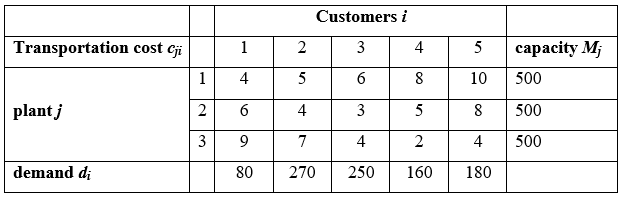
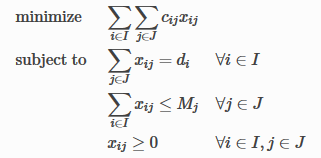
from: https://medium.com/analytics-vidhya/optimization-modelling-in-python-scipy-pulp-and-pyomo-d392376109f4

In [3]:
# Install pyomo in your system 
!pip install pyomo

In [1]:
# download from https://sourceforge.net/projects/winglpk/
# add GLPK/win64 to the system environment variable PATH

In [54]:
from pyomo.environ import *
from pyomo.opt import *

In [115]:
# ConcreteModel is model where data values supplied at the time of the model definition.
mTransport = ConcreteModel(name='Unbalanced Transportation Problem')

# all iterables are to be converted into Set objects
mTransport.i = Set(initialize=['Customer1', 'Customer2', 'Customer3','Customer4','Customer5'], doc='destinations')
mTransport.j = Set(initialize=['Plant1', 'Plant2', 'Plant3' ], doc='origins' )

In [116]:
mTransport.pA = Param(mTransport.i, initialize= {'Customer1': 80, 'Customer2': 270, 'Customer3': 250, 'Customer4': 160, 'Customer5': 180}, doc='destination demand')
mTransport.pB = Param(mTransport.j, initialize= {'Plant1' : 500, 'Plant2': 500, 'Plant3': 500 }, doc='origin capacity')

In [117]:
TransportationCost = {
    ('Customer1', 'Plant1'): 4,
    ('Customer1', 'Plant2'): 6,
    ('Customer1', 'Plant3'): 9,
    ('Customer2', 'Plant1'): 5,
    ('Customer2', 'Plant2'): 4,
    ('Customer2', 'Plant3'): 7,
    ('Customer3', 'Plant1'): 6,
    ('Customer3', 'Plant2'): 3,
    ('Customer3', 'Plant3'): 4,
    ('Customer4', 'Plant1'): 8,
    ('Customer4', 'Plant2'): 5,
    ('Customer4', 'Plant3'): 2,
    ('Customer5', 'Plant1'): 10,
    ('Customer5', 'Plant2'): 8,
    ('Customer5', 'Plant3'): 4
}

In [118]:
mTransport.pC = Param( mTransport.i, mTransport.j, initialize=TransportationCost, doc='per unit transportation cost')

In [119]:
# ## Define variables ##
mTransport.vX = Var ( mTransport.i, mTransport.j,bounds=(0.0,None), doc='units transported', within=NonNegativeReals)

In [122]:
# Define constraints ##
# Constraints: sum of goods <= factory capacity
def eDemand(mTransport, i):
    return sum(mTransport.vX[i,j] for j in mTransport.j) == mTransport.pA[i]
mTransport.eDemand = Constraint(mTransport.i, rule=eDemand, doc='maximum capacity of each origin')

# Constraints: sum of goods == customer demand
def eCapacity(mTransport, j):
    return sum(mTransport.vX[i,j] for i in mTransport.i) <= mTransport.pB[j]
mTransport.eCapacity = Constraint(mTransport.j, rule=eCapacity, doc='demand supply at destination' )

## Define objective and solve ##
def eCost(mTransport):
    return sum(mTransport.pC[i,j]*mTransport.vX[i,j] for i,j in mTransport.i*mTransport.j)
mTransport.eCost = Objective(rule=eCost, sense=minimize, doc='transportation cost')

    'pyomo.core.base.constraint.IndexedConstraint'>) on block Unbalanced
    Transportation Problem with a new Component (type=<class
    'pyomo.core.base.constraint.IndexedConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().


In [123]:
# output the LP file
mTransport.write('mTransport.lp', io_options={'symbolic_solver_labels': True})

mTransport.dual = Suffix(direction=Suffix.IMPORT)

Solver = SolverFactory('scip', executable='C:\\Program Files\\SCIPOptSuite 8.0.1\\bin\\scip.exe')

#Solver = SolverFactory('glpk')

SolverResults = Solver.solve(mTransport, tee=True)

SolverResults.write()

mTransport.pprint()

mTransport.vX.display()



SCIP version 8.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: Soplex 6.0.1] [GitHash: c84ee4283e]
Copyright (C) 2002-2022 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External libraries: 
  Soplex 6.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 8b86b300]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (github.com/coin-or/CppAD)
  MPIR 3.0.0           Multiple Precision Integers and Rationals Library developed by W. Hart (mpir.org)
  ZIMPL 3.5.2          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  AMPL/MP 4e2d45c4     AMPL .nl file reader library (github.com/ampl/mp)
  PaPILO 2.1.0         parallel presolve for integer and linear optimization (github.com/scipopt/papilo) [GitHash: 9363218]
  bliss 0.77           Computing Graph Automorphism Groups by T. Junttila and P. Kaski (www.tcs.hut.fi/Software/bliss/)
  Ipopt 

In [124]:
assignments = mTransport.vX.get_values().items()
EPS = 1.e-6
for (plant, customer),x in sorted(assignments):
    if x > EPS:
        print("sending quantity %10s from %3s to %3s" % (x, plant, customer))

sending quantity       80.0 from Customer1 to Plant1
sending quantity       20.0 from Customer2 to Plant1
sending quantity      250.0 from Customer2 to Plant2
sending quantity      250.0 from Customer3 to Plant2
sending quantity      160.0 from Customer4 to Plant3
sending quantity      180.0 from Customer5 to Plant3


In [125]:
 print("Objective function value = ", mTransport.eCost.expr())

Objective function value =  3210.0


#### Using "Scip" solver gets different result from "glpk"; Maybe "Scip" finds the global minimum.
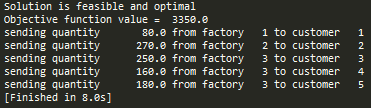

### References

    https://medium.com/analytics-vidhya/optimization-modelling-in-python-scipy-pulp-and-pyomo-d392376109f4
    https://pascua.iit.comillas.edu/aramos/simio/transpa/s_GoodOptimizationModelingPracticesPyomo.pdf
    https://github.com/Pyomo/PyomoGallery/blob/master/transport/transport.ipynb
    https://colab.research.google.com/github/jckantor/ND-Pyomo-Cookbook/blob/master/docs/03.01-Transportation-Networks.ipynb#scrollTo=KVTGAB_rmaBR
    https://groups.google.com/g/pyomo-forum/c/3UG5CtNnWcQ/m/0rYntwTUAQAJ
    https://www.ashishmenkudale.com/constrained-optimzation-in-python/
    https://medium.com/eni-digitalks/pyomo-101-a-dual-optimization-problem-cb7cb88c6e24
    https://www.youtube.com/watch?v=Y_tStwh2_O8
    

## Capacitated Facility Location Problem

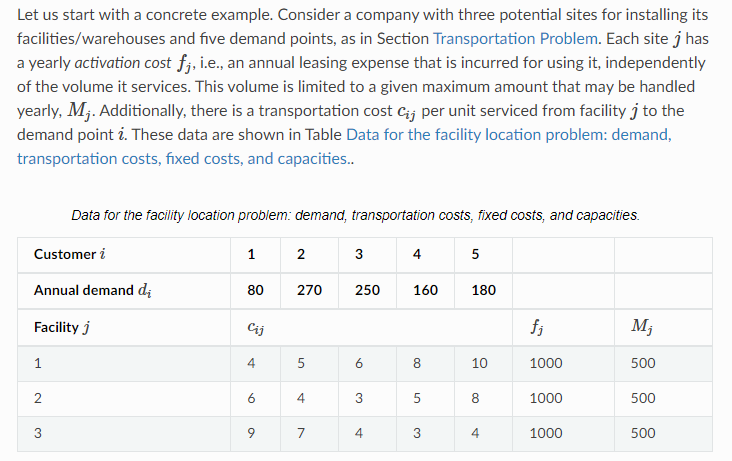
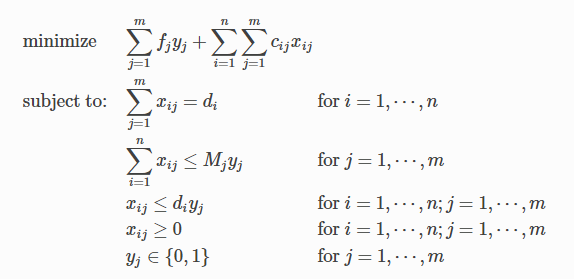
from : https://scipbook.readthedocs.io/en/latest/flp.html

In [126]:
from pyomo.environ import *
from pyomo.opt import *

In [130]:
# ConcreteModel is model where data values supplied at the time of the model definition.
mTransport = ConcreteModel(name='Capacitated facility location Problem')

# all iterables are to be converted into Set objects
mTransport.i = Set(initialize=['Customer1', 'Customer2', 'Customer3','Customer4','Customer5'], doc='destinations')
mTransport.j = Set(initialize=['Facility1', 'Facility2', 'Facility3' ], doc='origins' )

In [131]:
mTransport.pA = Param(mTransport.i, initialize={'Customer1': 80, 'Customer2': 270, 'Customer3': 250, 'Customer4': 160, 'Customer5': 180}, doc='destination demand')
mTransport.pB = Param(mTransport.j, initialize={'Facility1' : 500, 'Facility2': 500, 'Facility3': 500 }, doc='origin capacity' )
mTransport.pF = Param(mTransport.j, initialize={'Facility1' : 1000, 'Facility2': 1000, 'Facility3': 1000 }, doc='activation cost' )


In [132]:
TransportationCost = {
    ('Customer1', 'Facility1'): 4,
    ('Customer1', 'Facility2'): 6,
    ('Customer1', 'Facility3'): 9,
    ('Customer2', 'Facility1'): 5,
    ('Customer2', 'Facility2'): 4,
    ('Customer2', 'Facility3'): 7,
    ('Customer3', 'Facility1'): 6,
    ('Customer3', 'Facility2'): 3,
    ('Customer3', 'Facility3'): 4,
    ('Customer4', 'Facility1'): 8,
    ('Customer4', 'Facility2'): 5,
    ('Customer4', 'Facility3'): 3,
    ('Customer5', 'Facility1'): 10,
    ('Customer5', 'Facility2'): 8,
    ('Customer5', 'Facility3'): 4
}

In [133]:
mTransport.pC = Param(mTransport.i, mTransport.j, initialize=TransportationCost, doc='per unit transportation cost')

In [134]:
# ## Define variables ##
mTransport.vX = Var (mTransport.i, mTransport.j, bounds=(0.0,None), doc='units transported', within=NonNegativeReals)
mTransport.vY = Var (mTransport.j, doc='established flag', within=Binary)

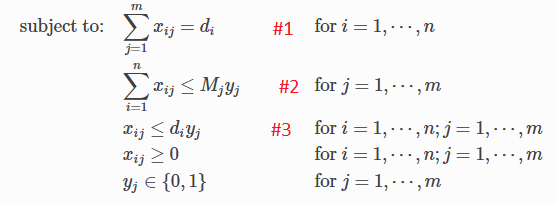

In [135]:
# Define constraints ##
# Constraint #1: sum of goods == customer demand
def eDemand(mTransport, i):
    return sum(mTransport.vX[i,j] for j in mTransport.j) == mTransport.pA[i]
mTransport.eDemand = Constraint(mTransport.i, rule=eDemand, doc='maximum capacity of each origin')

# Constraint #2: sum of goods <= factory capacity
def eCapacity(mTransport, j):
    return sum(mTransport.vX[i,j] for i in mTransport.i) <= mTransport.pB[j] * mTransport.vY[j]
mTransport.eCapacity = Constraint(mTransport.j, rule=eCapacity, doc='demand supply at destination' )

# Constraint #3:
def eDemandBounds(mTransport,i,j):
    return mTransport.vX[i,j] <= mTransport.pA[i] * mTransport.vY[j]
mTransport.eDemandBounds = Constraint(mTransport.i,mTransport.j, rule=eDemandBounds, doc='maximum Demand limit')

In [136]:
## Define objective ##
def eCost(mTransport):
    return sum(mTransport.pC[i,j]*mTransport.vX[i,j] for i,j in mTransport.i*mTransport.j) + \
           sum(mTransport.pF[j]*mTransport.vY[j] for j in mTransport.j)  
mTransport.eCost = Objective(rule=eCost, sense=minimize, doc='transportation cost')

In [137]:
# output the LP file
mTransport.write('mTransport.lp', io_options={'symbolic_solver_labels': True})

mTransport.dual = Suffix(direction=Suffix.IMPORT)

Solver = SolverFactory('scip', executable='C:\\Program Files\\SCIPOptSuite 8.0.1\\bin\\scip.exe')

## solve ##

SolverResults = Solver.solve(mTransport, tee=True)

SolverResults.write()

mTransport.pprint()

mTransport.vX.display()

SCIP version 8.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: Soplex 6.0.1] [GitHash: c84ee4283e]
Copyright (C) 2002-2022 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External libraries: 
  Soplex 6.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 8b86b300]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (github.com/coin-or/CppAD)
  MPIR 3.0.0           Multiple Precision Integers and Rationals Library developed by W. Hart (mpir.org)
  ZIMPL 3.5.2          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  AMPL/MP 4e2d45c4     AMPL .nl file reader library (github.com/ampl/mp)
  PaPILO 2.1.0         parallel presolve for integer and linear optimization (github.com/scipopt/papilo) [GitHash: 9363218]
  bliss 0.77           Computing Graph Automorphism Groups by T. Junttila and P. Kaski (www.tcs.hut.fi/Software/bliss/)
  Ipopt 

In [140]:
assignments = mTransport.vX.get_values().items()
EPS = 1.e-6
for (customer,Facility),x in sorted(assignments):
    if x > EPS:
        print("sending quantity %10s from %3s to %3s" % (x, Facility, customer))

sending quantity       80.0 from Facility2 to Customer1
sending quantity      270.0 from Facility2 to Customer2
sending quantity      150.0 from Facility2 to Customer3
sending quantity      100.0 from Facility3 to Customer3
sending quantity      160.0 from Facility3 to Customer4
sending quantity      180.0 from Facility3 to Customer5


In [141]:
 print("Objective function value = ", mTransport.eCost.expr())

Objective function value =  5610.0


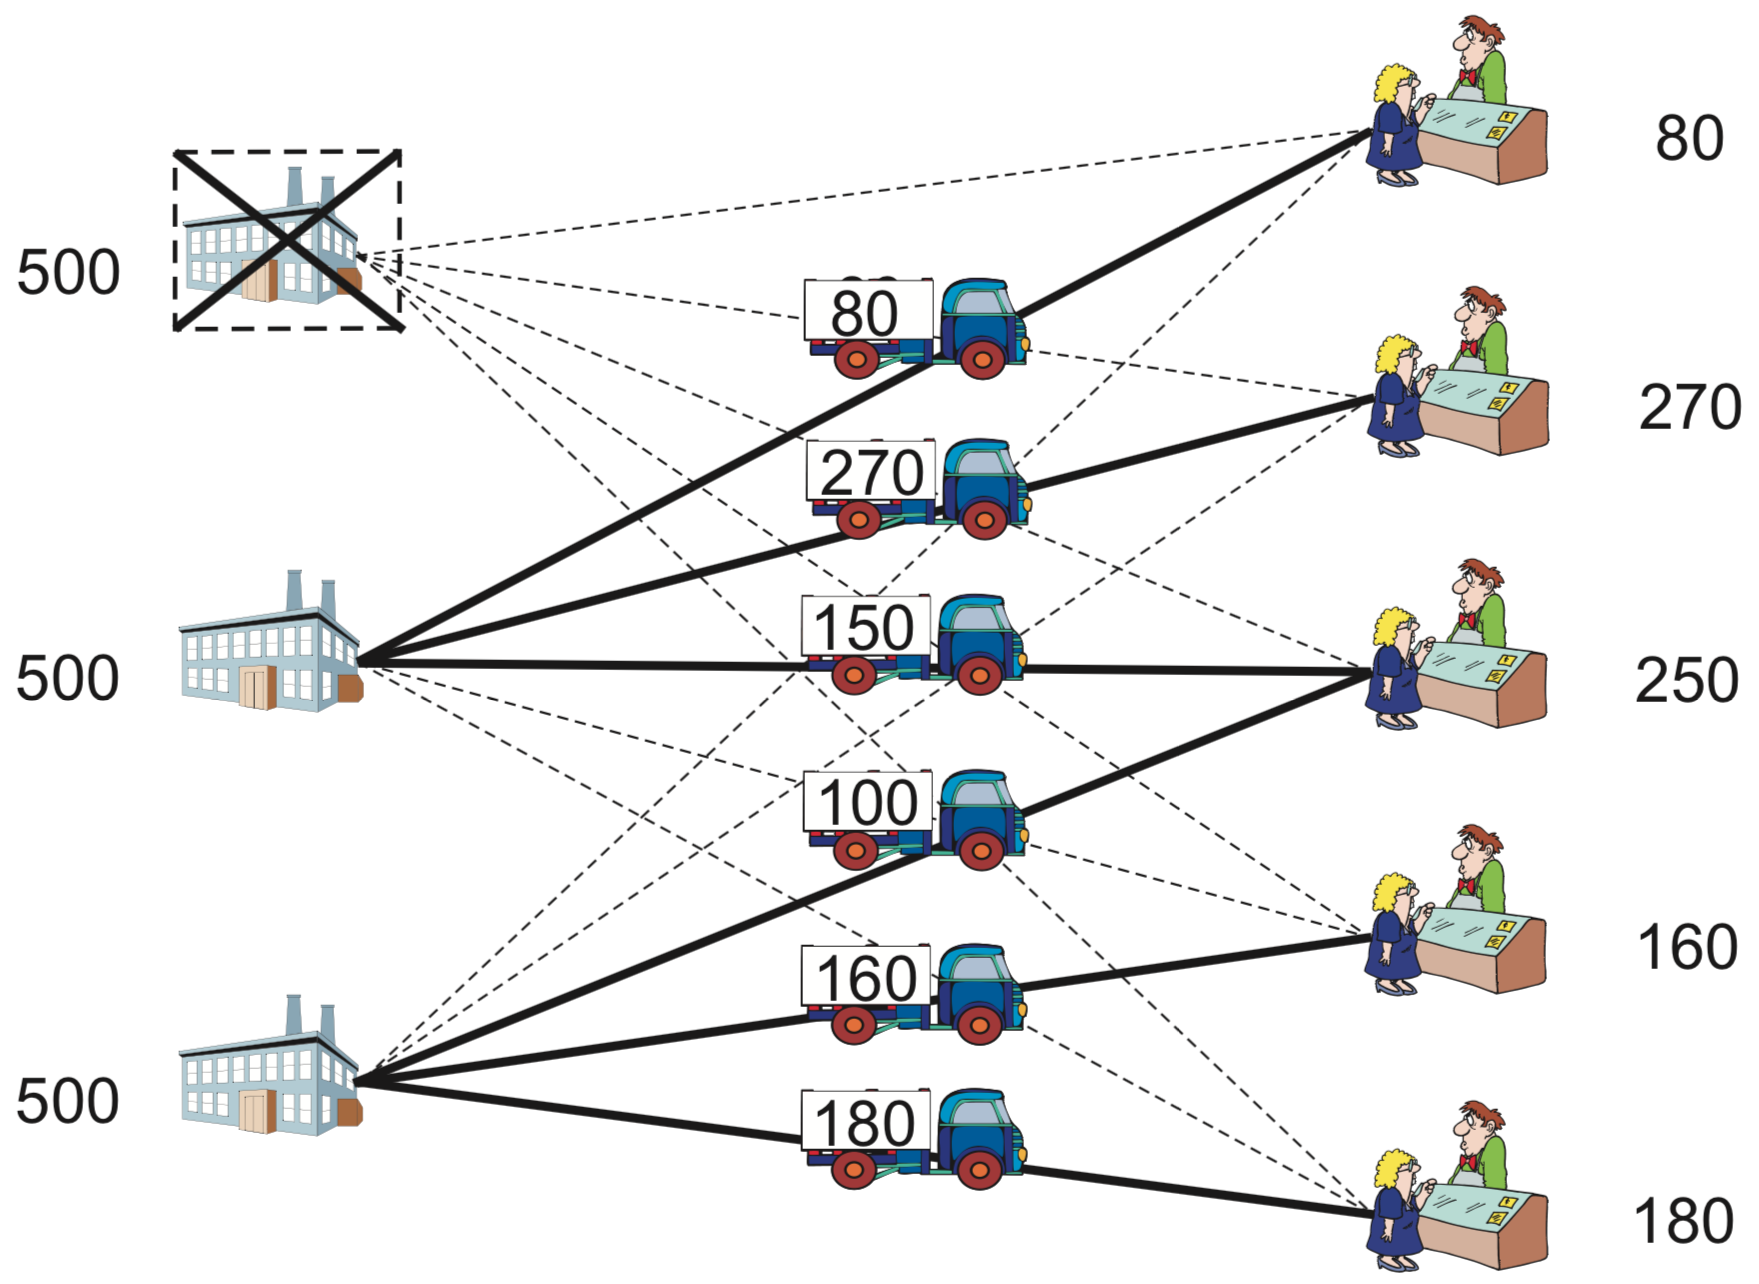
from: https://scipbook.readthedocs.io/en/latest/flp.html

### References
    https://scipbook.readthedocs.io/en/latest/flp.html
    https://github.com/hakeemrehman/Python-PuLP-/blob/master/Capacitated%20Facility%20Location%20Problem.ipynb

# Transhippment problem

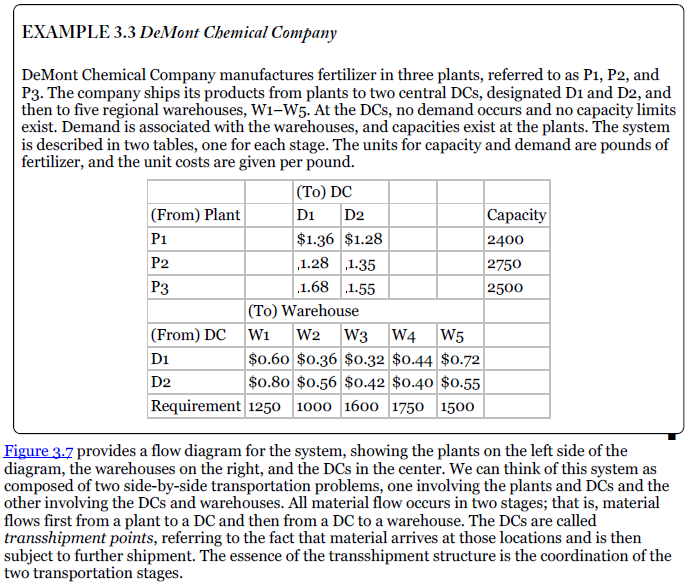
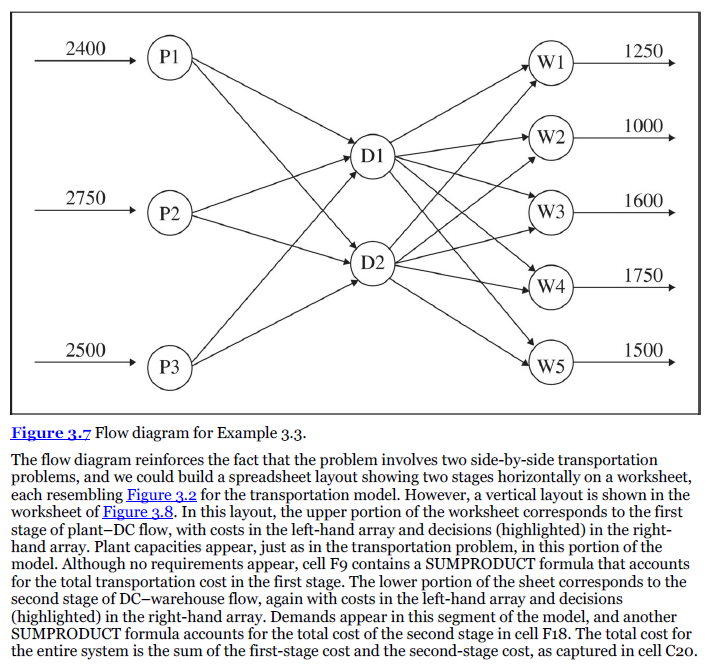
from: Kenneth R. Baker - Optimization Modeling With Spreadsheets-WILEY (2016)

In [30]:
from pyomo.environ import *
from pprint import pprint

In [31]:
#### Data Inputs ####

Plant = ["P1", "P2", "P3"]
Warehouse = ["W1", "W2", "W3", "W4", "W5"]
Central = ["D1", "D2"]

CAP = {"P1": 2400, "P2": 2750, "P3": 2500}
DEM = {"W1": 1250, "W2": 1000, "W3": 1600, "W4": 1750, "W5": 1500}

CostFromPlantToCentral = {
        ("P1", "D1"): 1.36,
        ("P1", "D2"): 1.28,
        ("P2", "D1"): 1.28,
        ("P2", "D2"): 1.35,
        ("P3", "D1"): 1.68,
        ("P3", "D2"): 1.55 }

CostFromCentralTowarehouse = {
        ("D1", "W1"): 0.60,
        ("D1", "W2"): 0.36,
        ("D1", "W3"): 0.32,
        ("D1", "W4"): 0.44,
        ("D1", "W5"): 0.72,
        ("D2", "W1"): 0.80,
        ("D2", "W2"): 0.56,
        ("D2", "W3"): 0.42,
        ("D2", "W4"): 0.40,
        ("D2", "W5"): 0.55}

In [32]:
model = ConcreteModel(name="Transshipment problem")

model.Plant = Set(initialize = Plant)
model.Central = Set(initialize = Central)
model.Warehouse = Set(initialize = Warehouse)

model.a = Param(model.Plant, initialize = CAP)
model.b = Param(model.Warehouse, initialize= DEM)

In [33]:
model.C1 = Param(model.Plant, model.Central, initialize = CostFromPlantToCentral)
model.C2 = Param(model.Central, model.Warehouse, initialize = CostFromCentralTowarehouse)

In [34]:
model.X = Var(model.Plant, model.Central, within = PositiveReals)
model.Y = Var(model.Central, model.Warehouse, within = PositiveReals)

In [35]:
def objective_rule(model):
    return sum(model.C1[i,j] * model.X[i,j] for i in model.Plant for j in model.Central) + \
           sum(model.C2[i,j] * model.Y[i,j] for i in model.Central for j in model.Warehouse)
           
model.objective = Objective(rule=objective_rule, sense=minimize)

In [36]:
def supply_rule(model, i):
    return sum(model.X[i,j] for j in model.Central) <= model.a[i]

model.supply = Constraint(model.Plant, rule=supply_rule)

In [37]:
def demand_rule(model, j):
    return sum(model.Y[i,j] for i in model.Central) >= model.b[j]

model.demand = Constraint(model.Warehouse, rule=demand_rule)

In [47]:
# https://www.hackerearth.com/practice/notes/the-knapsack-problem/
from IPython.display import display, Image, SVG, Math, YouTubeVideo
Image(url ='https://groups.google.com/group/pyomo-forum/attach/1d404b727b6d2/formula.png?part=0.2&view=1', width=300, height=300)

In [38]:
def transsphipment_rule(model, k):
    return sum(model.X[i,k] for i in model.Plant) - sum(model.Y[k,j] for j in model.Warehouse) == 0

model.transshipment = Constraint(model.Central ,rule=transsphipment_rule)

In [39]:
opt = SolverFactory('scip', executable='C:\\Program Files\\SCIPOptSuite 8.0.1\\bin\\scip.exe')


In [40]:
SolverResults = opt.solve(model, tee=True)

SolverResults.write()

model.pprint()


SCIP version 8.0.1 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: Soplex 6.0.1] [GitHash: c84ee4283e]
Copyright (C) 2002-2022 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External libraries: 
  Soplex 6.0.1         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 8b86b300]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (github.com/coin-or/CppAD)
  MPIR 3.0.0           Multiple Precision Integers and Rationals Library developed by W. Hart (mpir.org)
  ZIMPL 3.5.2          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  AMPL/MP 4e2d45c4     AMPL .nl file reader library (github.com/ampl/mp)
  PaPILO 2.1.0         parallel presolve for integer and linear optimization (github.com/scipopt/papilo) [GitHash: 9363218]
  bliss 0.77           Computing Graph Automorphism Groups by T. Junttila and P. Kaski (www.tcs.hut.fi/Software/bliss/)
  Ipopt 

In [43]:
print("Objective total cost = $", model.objective.expr())

Objective total cost = $ 12849.5


In [44]:
model.X.display()
model.Y.display()

X : Size=6, Index=X_index
    Key          : Lower : Value  : Upper : Fixed : Stale : Domain
    ('P1', 'D1') :     0 : 1100.0 :  None : False : False : PositiveReals
    ('P1', 'D2') :     0 : 1300.0 :  None : False : False : PositiveReals
    ('P2', 'D1') :     0 : 2750.0 :  None : False : False : PositiveReals
    ('P2', 'D2') :     0 :    0.0 :  None : False : False : PositiveReals
    ('P3', 'D1') :     0 :    0.0 :  None : False : False : PositiveReals
    ('P3', 'D2') :     0 : 1950.0 :  None : False : False : PositiveReals
Y : Size=10, Index=Y_index
    Key          : Lower : Value  : Upper : Fixed : Stale : Domain
    ('D1', 'W1') :     0 : 1250.0 :  None : False : False : PositiveReals
    ('D1', 'W2') :     0 : 1000.0 :  None : False : False : PositiveReals
    ('D1', 'W3') :     0 : 1600.0 :  None : False : False : PositiveReals
    ('D1', 'W4') :     0 :    0.0 :  None : False : False : PositiveReals
    ('D1', 'W5') :     0 :    0.0 :  None : False : False : PositiveReals

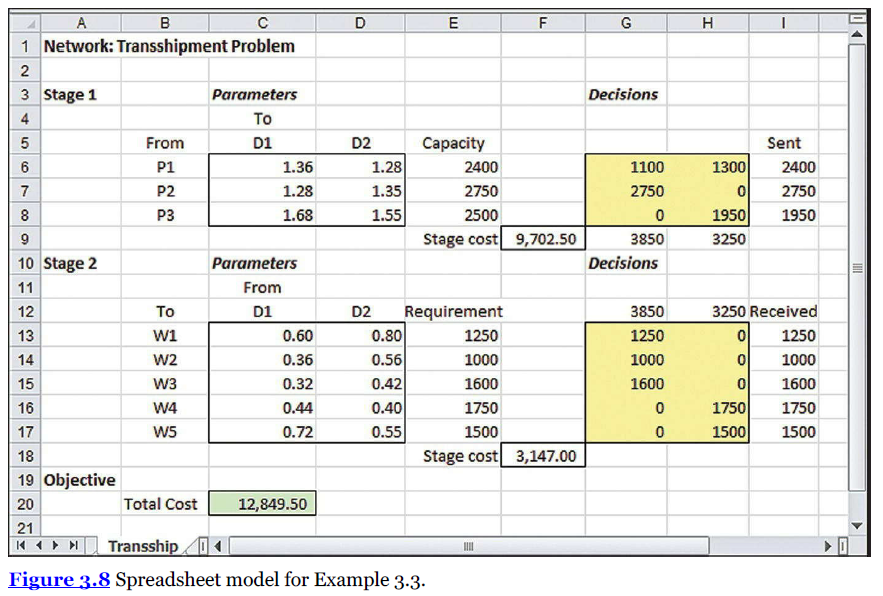

### References    
    
    https://groups.google.com/g/pyomo-forum/c/3UG5CtNnWcQ
    https://scipbook.readthedocs.io/en/latest/flp.html
    https://www.youtube.com/watch?v=HBahE5MO9uE
    https://machinelearninggeek.com/transshipment-problem-in-python-using-pulp/
    